In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
%matplotlib notebook

In [3]:
cx = [1, 2]
cy = [0, 0]
sig = [1, 1]
p = 0.4

N = 10

In [4]:

samples = []
for i in range(N):
    if np.random.uniform() < p:
        c = 0
    else:
        c = 1
    x, y = np.random.multivariate_normal(
        (cx[c], cy[c]), [[sig[c], 0], [0, sig[c]]])
    samples.append({"c": c, "x": x, "y": y})


all parameters are constant except $p$, which will be inferred by our EM 

all samples are observed except the last sample which we will hide:

In [5]:
p = None
samples[N-1]["c"] = None

<IPython.core.display.Javascript object>


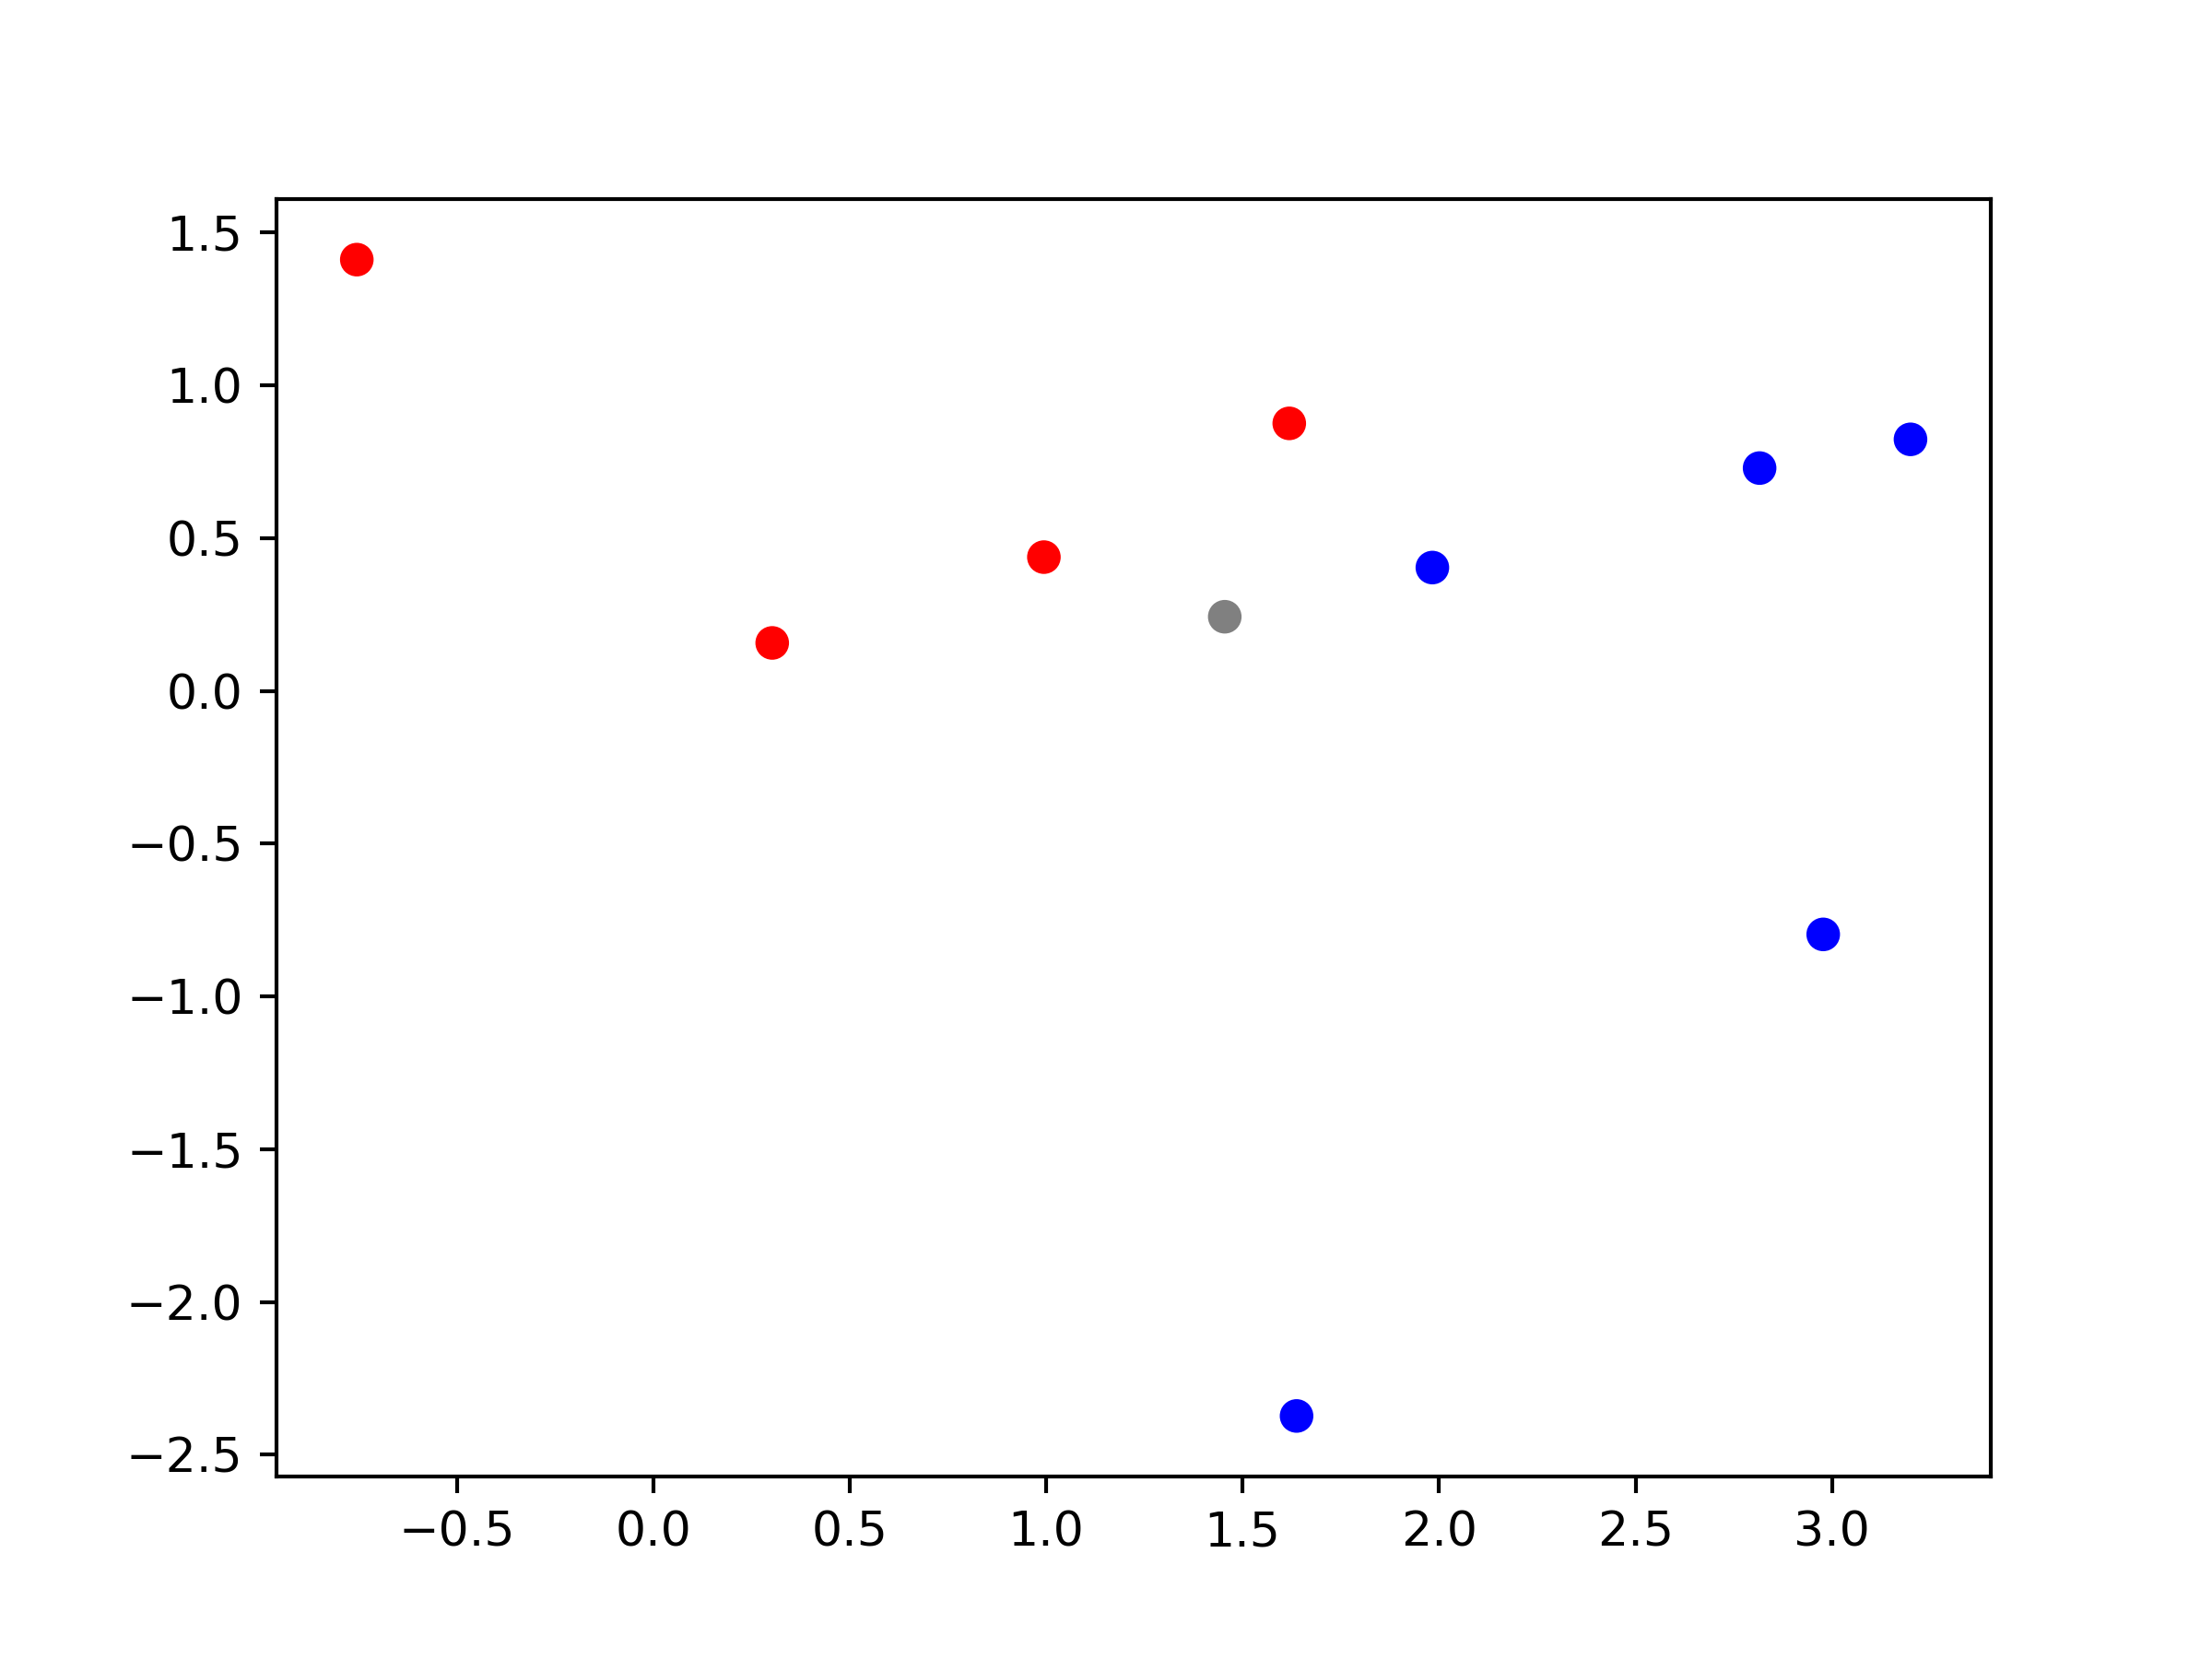

In [6]:
def color_key(c):
    if c == 0: 
        return 'r'
    elif c == 1:
        return 'b'
    else: 
        return 'gray'
plt.scatter([t["x"] for t in samples], [t["y"] for t in samples],
           color = [color_key(t["c"]) for t in samples])
plt.show()

the $q$ function is used for the sufficient statistics, and works in 3 modes:

1. for observed samples it simply returns the observed cluster
2. for expected likelihood it is given a $c$ which is the current distribution over the hidden parameter
3. for data likelihood it estimates the probability for each cluster according to the parameters

In [7]:
def q(i, k, c, p):
    s = samples[i]
    if s['c'] is not None:
        # observed sample
        return (1 if s['c'] == k else 0)
    elif c is not None:
        # expected likelihood given c
        return (c if k == 0 else 1-c)
    else:
        # data likelihood 
        prob = (p if k==0 else 1-p) / (2 * np.pi * sig[k]**2) * \
            np.exp(-((s['x'] - cx[k])**2 + (s['y'] - cy[k])**2) / (2 * sig[k]**2))
        return prob

def q_sum(i, c, p):
    return q(i, 0, c, p) + q(i, 1, c, p)

sufficient statistics:

In [8]:

def n1(k, c, p):
    return sum([1*q(i, k, c, p)/q_sum(i, c, p) for i, s in enumerate(samples)])
    
def n2(k, c, p):
    return sum([s['x']*q(i, k, c, p)/q_sum(i, c, p) for i, s in enumerate(samples)])

def n3(k, c, p):
    return sum([s['y']*q(i, k, c, p)/q_sum(i, c, p) for i, s in enumerate(samples)])

def n4(k, c, p):
    return sum([0.5*(s['x']**2 + s['y']**2)*q(i, k, c, p)/q_sum(i, c, p) for 
                i, s in enumerate(samples)])


In [9]:

def likelihood(c, p):
    l = 0
    for k in [0]:
        l += n1(k, c, p)*(np.log((p if k==0 else 1-p))-\
                          np.log(2*np.pi*sig[k]**2)-\
                          cx[k]**2/(2*sig[k]**2) - cy[k]**2/(2*sig[k]**2))
        l += n2(k, c, p)*cx[k]/(sig[k]**2)
        l += n3(k, c, p)*cy[k]/(sig[k]**2)
        l += n4(k, c, p)*(-1)/(sig[k]**2)
    return l


In [10]:
@np.vectorize
def data_likelihood(c, p):
    return likelihood(None, p)

@np.vectorize
def expected_likelihood(c, p):
    return likelihood(c, p)



In [11]:
my_c, my_p = np.meshgrid(np.linspace(0.01, 0.99, 30), np.linspace(0.01, 0.99, 30))

In [12]:
l1 = data_likelihood(my_c, my_p)
l2 = expected_likelihood(my_c, my_p)


<IPython.core.display.Javascript object>


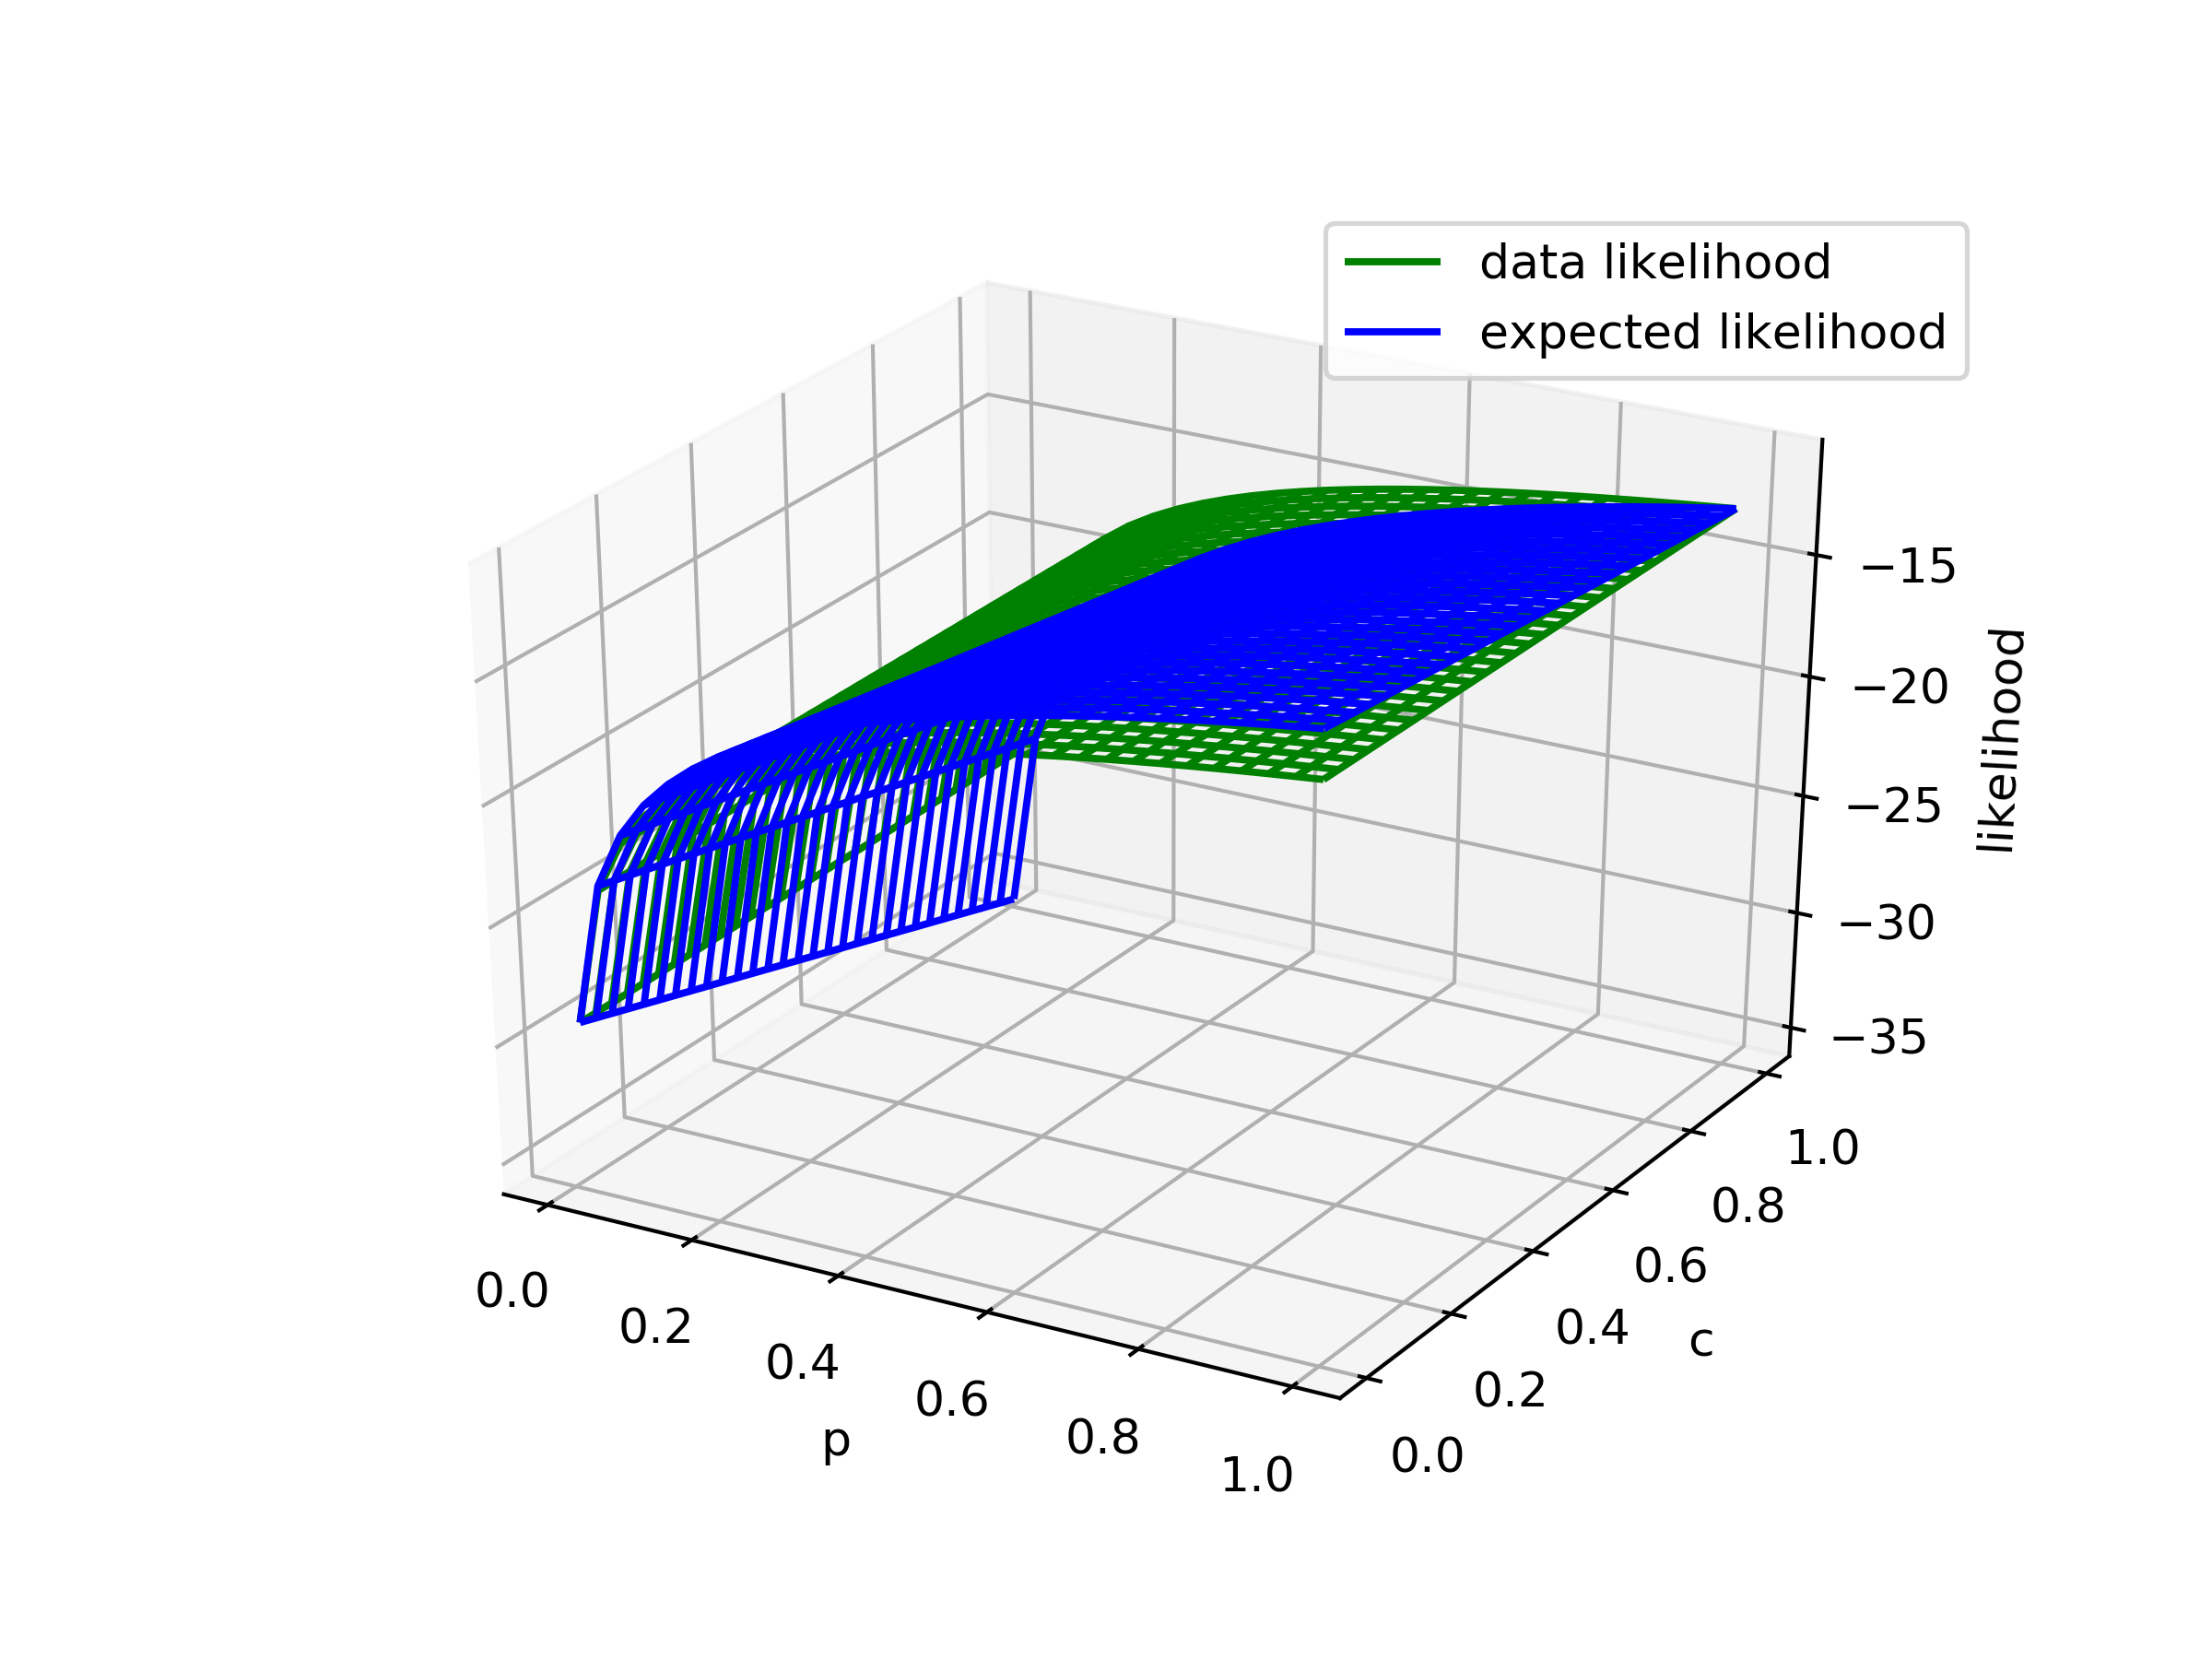

In [13]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_wireframe(my_p, my_c, l1, color='green', label='data likelihood')
ax.plot_wireframe(my_p, my_c, l2, color='blue', label='expected likelihood')

ax.set_xlabel('p')
ax.set_ylabel('c')
ax.set_zlabel('likelihood')
ax.legend()
plt.show()

we'll start by guessing $p=0.5$:

<IPython.core.display.Javascript object>


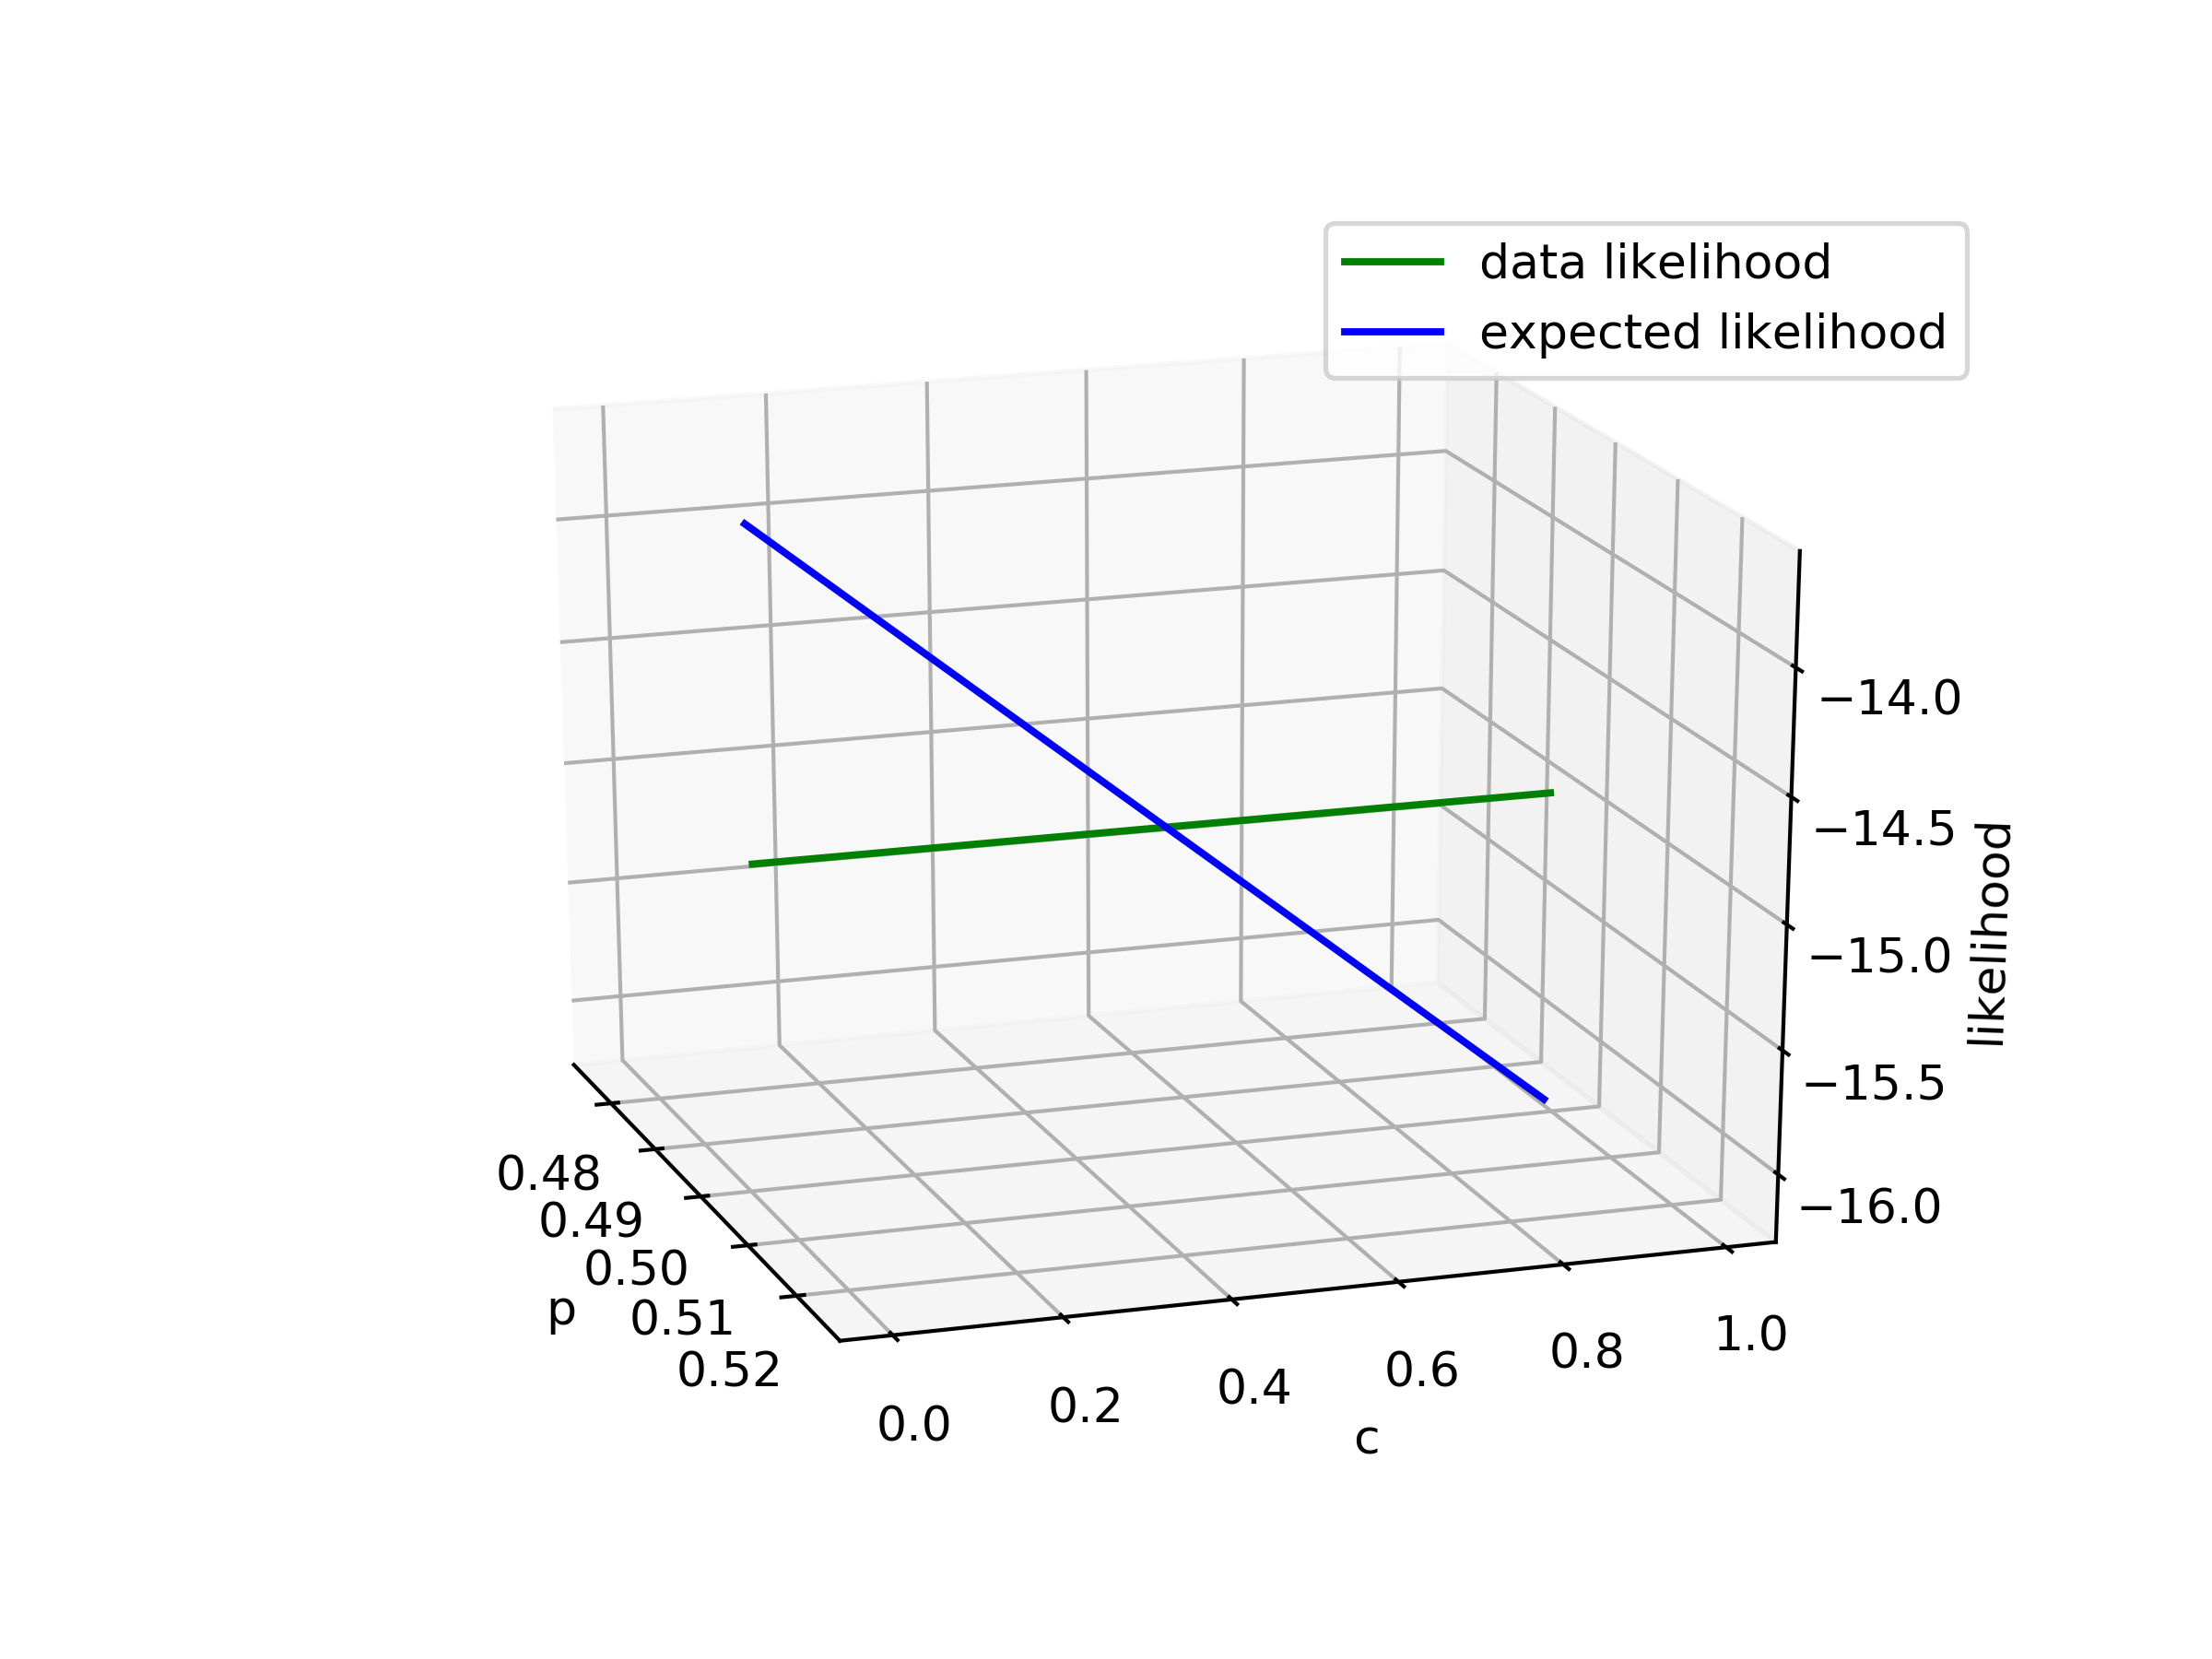

In [14]:
my_p = np.repeat(0.5, 30)
my_c = np.linspace(0.01, 0.99, 30)
l1 = data_likelihood(my_c, my_p)
l2 = expected_likelihood(my_c, my_p)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot3D(my_p, my_c, l1, color='green', label='data likelihood')
ax.plot3D(my_p, my_c, l2, color='blue', label='expected likelihood')

ax.set_xlabel('p')
ax.set_ylabel('c')
ax.set_zlabel('likelihood')
ax.legend()
plt.show()